In [235]:
import os
import re
from typing import List, Union
from glob import glob
from pathlib import Path
import zipfile
import tempfile

import numpy as np
import pandas as pd
from requests import HTTPError

import cdsapi
import xarray as xr

from caseva.models import ThresholdExcessModel


In [ ]:
PATH_ROOT = Path().resolve()
PATH_DATA = PATH_ROOT / "data"
PATH_DATA.mkdir(exist_ok=True)

COPERNICUS_DATASET = "sis-european-wind-storm-indicators"
COPERNICUS_PRODUCT = "windstorm_footprints"

LAT_CHNKS = 152
LON_CHNKS = 232
EVENT_CHNKS = -1  # No chunking over this dimension

## Prepare data requests

In [ ]:
def pad(num: int) -> str:
    """Integer formatting compatible with the API request syntax.
    
    Examples
    --------
    pad(2) -> "02"
    pad(10) -> "10"
    """
    return f"{num:02d}"

# The 9th day of the month is missing from the dataset (= no events).
days = [pad(i) for i in range(1, 32) if  i != 9]
winter_months = [pad(i) for i in [1, 2, 3, 10, 11 , 12]]

missing_yrs = [2003, 2004, 2010, 2018, 2019]
years = [str(yr) for yr in range(1979, 2022) if yr not in missing_yrs]

In [ ]:
def download_data_files(
    years: List[str],
    months: List[str],
    days: List[str],
    save_dir: Union[str, Path]
) -> None:
    """Fetch wind footprint data files from the Copernicus API.
    
    Parameters
    ----------
    years : list of str
        List of years to fetch.
    months : list of str
        List of months to fetch.
    days : list of str
        List of days to fetch.
    save_dir : str | Path
        Directory for storing the temporary raw data files.
    """
    client = cdsapi.Client()

    for year in years:

        print(f"Processing year {year}...")
        for month in months:

            request = {
                "product": [COPERNICUS_PRODUCT],
                "variable": "all",
                "year": [year],
                "month": [month],
                "day": days,
            }

            target = os.path.join(save_dir, f"{year}_{month}.zip")

            try:
                client.retrieve(COPERNICUS_DATASET, request, target)
            except HTTPError:
                print(f"Download failed for {target}. Likely missing from data.")


## Prepare data processing steps

In [184]:
def _extract_timestamp(fname: str) -> pd.Timestamp:
    """Extract timestamp from filename.
    
    Parameters
    ----------
    fname : str
        Name of the netcdf file to process.

    Returns
    -------
    pd.Timestamp
        Date corresponding to the wind data of that file.
    """
    time_str = re.search(r'(\d{8})', fname).group(1)
    return pd.to_datetime(time_str)

In [185]:
def _infer_spatial_dims(ds):

    lon_candidates = ["longitude", "lon", "lng", "x"]
    lat_candidates = ["latitude", "lat", "y"]
    
    lower_dims = {dim.lower(): dim for dim in ds.dims}

    lon_dims = [lower_dims[dim] for dim in lower_dims if dim in lon_candidates]
    lat_dims = [lower_dims[dim] for dim in lower_dims if dim in lat_candidates]

    if len(lon_dims) != 1 or len(lat_dims) != 1:
        raise ValueError("Could not find unique lon/lat names.")
    
    return (lon_dims[0], lat_dims[0])

In [ ]:
def preprocess(ds: xr.Dataset) -> xr.Dataset:
    """Preprocess `ds` before it is read with the xr.open_mfdataset."""

    # Parse time coordinate stamp from the .nc filename.
    filename = ds.encoding['source']
    timestamp = _extract_timestamp(filename)

    # Redundant coords to drop.
    drop_coords = [coord for coord in ds.coords if coord in ["time", "z"]]
    for coord in drop_coords:
        ds = ds.drop_vars(coord)

    # `varname` is sometimes 'FX', 'max_wind_speed', etc...
    varname = list(ds.data_vars)[0]
    xname, yname = _infer_spatial_dims(ds)
    return (
        ds
        .squeeze()
        .expand_dims(date=[timestamp])
        .rename({varname: "wind_footprint", xname: "lon", yname: "lat"})
    )

## Download the datasets

In [ ]:
with tempfile.TemporaryDirectory() as tmpdir:

    # Load zip files from Copernicus data store.
    download_data_files(years, winter_months, days, save_dir=tmpdir)

    # Unpack all zipped netcdf files.
    zipfiles = glob(os.path.join(tmpdir, "*.zip"))
    for zfile in zipfiles:
        with zipfile.ZipFile(zfile, "r") as file_ref:
            file_ref.extractall(tmpdir)

    # Combine all netcdf files into a single dataset.
    ncfiles = glob(os.path.join(tmpdir, "*.nc"))

    # Note: chunking done before renaming. Also, chunking is done on a
    # file-by-file basis, meaning that the "event" dimension (corresponding
    # to each netcdf file needs to be chunked separately afterwards).

    ds = xr.open_mfdataset(
        ncfiles,
        preprocess=preprocess,
        chunks={"Latitude": LAT_CHNKS, "Longitude": LON_CHNKS}
    )["wind_footprint"].chunk({"event": EVENT_CHNKS})

    # Write to a zarr file. 
    ds.to_zarr(PATH_DATA / "wind_footprints.zarr", compute=True, mode="w")

### First glance at the full dataset

In [357]:
ds = xr.open_zarr(PATH_DATA / "wind_footprints.zarr")["wind_footprint"]
ds = ds.sortby("event")

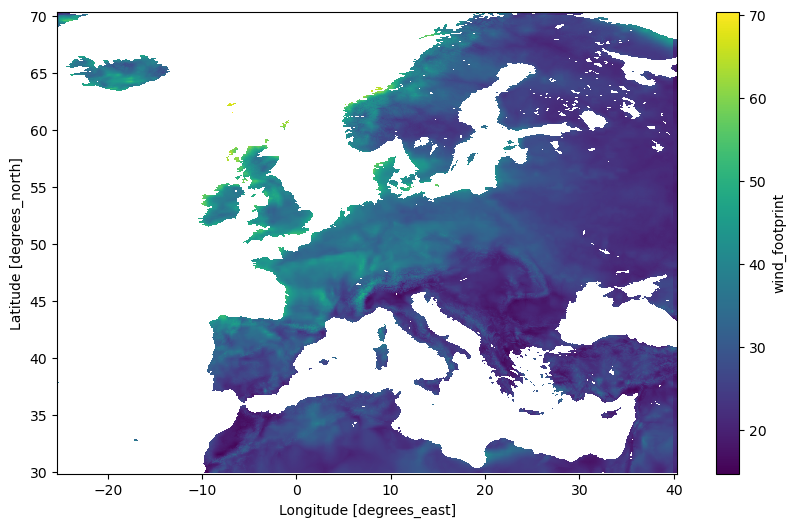

In [358]:
ds.max("event").plot(figsize=(10, 6))

## Fit the extreme value distributions

In [397]:
time_diffs = ds.event.diff("event")
date_mask = time_diffs < np.timedelta64(3, "D")

first_event_mask = ds.event[0].copy(data=False)
date_mask = xr.concat([first_event_mask, date_mask], dim="event")

ds = ds.where(~date_mask, drop=True)

In [ ]:
all_years = pd.DatetimeIndex(ds.event).year
num_years = all_years.max() - all_years.min() + 1

In [398]:
def fit_gpd(data, num_years=43, debug=False):

    if np.isnan(data).all():
        return np.nan
    elif data[data > 0].size < 5:
        return 0
    
    model = ThresholdExcessModel()
    threshold = np.quantile(data, 0.90)

    model.fit(data=data, threshold=threshold, num_years=num_years)

    if debug:
        model.diagnostic_plot()
    return model.return_level(100)["level"]

In [403]:
model = ThresholdExcessModel()
data = ds.sel(lon=6, lat=45, method="nearest").compute()

array([37.75777115])

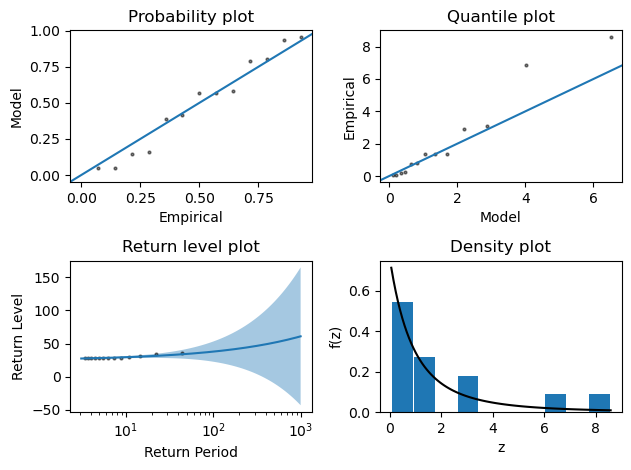

In [404]:
fit_gpd(data, debug=True)

## Plot the result